In [11]:
import sys
#import Backtest
from GeneralBacktest import Backtest,Position,Bid
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import pickle
import yfinance as yf
import pandas_ta as ta
#warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure

In [4]:
data = pd.read_csv("test_data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)

In [7]:
macd = data.ta.macd(close='AAPL', fast=12, slow=26, signal=9, append=False)

In [370]:
def get_data(tickers,length,interval):
    data =  yf.download(tickers = tickers, 
    period = length, interval = interval, group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
)

    data = data.loc[:, pd.IndexSlice[:, ['Close']]]

    columns = data.columns.droplevel(1)

    data.columns = columns 

    data.sort_index(axis = 1, inplace = True)
    #data = data.reset_index(drop = True)
    return data.dropna()

with open("sp100tickers.pickle", "rb") as f:
    tickers = pickle.load(f)
data = get_data(tickers,'30d','15m')

[*********************100%***********************]  100 of 100 completed


In [386]:
class MACD:
    def __init__(self,data):
        self.data = data
        self.macd = self.get_macd(data)
        self.signal_change = (self.macd*self.macd.shift(1)).lt(0)
        
    def get_macd(self,data):
        res = pd.DataFrame()
        for ticker in data.columns:
            macd = data.ta.macd(close=ticker, fast=12, slow=26, signal=9, append=False)
            res[ticker] = macd['MACD_12_26_9'].rolling(10).mean()
        res.index = data.index
        return res
    
    def get_targets(self,ti):
        buying = []
        selling = []
        
        keys = self.signal_change.loc[ti]
        keys = keys[keys>0].keys()
        
        for key in keys:
            if self.macd.loc[ti][key] > 0:
                buying.append(key)
            else:
                selling.append(key)
        
        
        
        return buying, selling
        
    def get_trend(self,df,i):
        trend = df.pct_change().mean(axis = 1).ewm(com=0.1).mean().rolling(30).mean()
        
        return trend[-1]
        
        
    
    def clear_positions(self,ti,df,positions):
        bid_list = []
        for pos in positions.values():
            bid = Bid(ticker = pos.ticker,shares = pos.shares,price = df.iloc[-1][pos.ticker],bid_type = 0)
            bid_list.append(bid)
        return bid_list
        
    def build_positions(self,ti,df,cash,positions):
        bid_list = []
        for ticker in df.columns:
            price = df.iloc[-1][ticker]
            shares = cash/len(df.columns)//price
            bid = Bid(ticker = ticker,shares = shares,price = price,bid_type = 1)
            bid_list.append(bid)
        return bid_list
    
    
        
    def predict(self,ti,df,positions,cash,full_data):
#         if ti.minute == 0 or ti.minute == 30:
#             print("================={}=================".format(ti))
        bid_list = []
        trend = self.get_trend(df,100)

        if trend < -0.0003:
            print(trend)
            bid_list+=self.clear_positions(ti,df,positions)
            return bid_list
                    
    
        if trend > 0.0004:
            if len(positions) == 0:
                print(trend)
                bid_list += self.build_positions(ti,df,cash,positions)
        
#         buying,selling = self.get_targets(ti)
#         total_position_value = sum([pos.shares * pos.price for pos in positions.values()])
#         for pos in positions.values():
#             ret = (pos.price - pos.wa_cost_price)/pos.wa_cost_price
#             if  pos.ticker in selling:
#                 bid = Bid(ticker = pos.ticker,shares = pos.shares,price = df.iloc[-1][pos.ticker],bid_type = 0)
#                 bid_list.append(bid)
#                 cash+=pos.shares * pos.price
#                 total_position_value -= pos.shares * pos.price
        
        

            
#         for ticker in buying:
#             price = df.iloc[-1][ticker]
#             amount = cash/len(buying)
#             shares = amount//price
#             bid = Bid(ticker = ticker, shares = shares, price = price,bid_type = 1)
#             bid_list.append(bid)

        
        return bid_list
            
        

# Load sample data

In [387]:
data1 = data.iloc[:,:10]
macd = MACD(data)
macd_bt = Backtest(data, macd)
macd_bt.backtest_full()

====================Start====================

-0.00033706733590068864
-0.0003110083351843929
-0.0003289084591367416
-0.0003174390428576678
-0.000401196131099116
-0.0005033066954244619
-0.0005065530254775695
-0.0005953918461394709
-0.0005626372294330633
-0.0005250817966312094
-0.000560380000790939
-0.0006340417342853108
-0.0005982322382422317
-0.00042501552510434916
-0.00042978068591993754
-0.0004971642712526349
-0.0005060535133696842
-0.0003631866702011251
-0.00035324153591490394
-0.0004307364925169957
-0.0003420903495931079
-0.0003160737593511845
-0.00037124414185477664
-0.0003797563676671242
-0.0003413226024700866
-0.00030378284375413904
-0.0005115074209085049
-0.0005377519986928115
-0.00039697197401091845
-0.00034779807614515227
-0.0005058017387204394
-0.00046435792044243645
-0.0005247986770982783
-0.0006923147087909739
-0.0008584715291381071
-0.0007662625234031756
-0.0008077603299130626
-0.0009698008605267059
-0.0009558356610619952
-0.0009784211851009354
-0.0008797860175420257
-0.

# After backtest, check all historical transactions with transaction_history, a dataframe that recorded each bid, its transaction cost and pnl.

In [388]:
macd_bt.transaction_history

,dt,ticker,type,price,shares,amount,transaction_cost,pnl
0,2022-09-07 13:45:00-04:00,AAPL,1,155.550003,6.0,933.300018,0.0,0.000000
1,2022-09-07 13:45:00-04:00,ABBV,1,138.134995,7.0,966.944962,0.0,0.000000
2,2022-09-07 13:45:00-04:00,ABT,1,104.580002,9.0,941.220016,0.0,0.000000
3,2022-09-07 13:45:00-04:00,ACN,1,286.630005,3.0,859.890015,0.0,0.000000
4,2022-09-07 13:45:00-04:00,ADBE,1,377.250000,2.0,754.500000,0.0,0.000000
...,...,...,...,...,...,...,...,...
985,2022-10-05 10:45:00-04:00,VZ,0,38.924999,24.0,934.199982,0.0,-9.120026
986,2022-10-05 10:45:00-04:00,WBA,0,32.794998,29.0,951.054947,0.0,10.149956
987,2022-10-05 10:45:00-04:00,WFC,0,42.599998,23.0,979.799965,0.0,24.782486
988,2022-10-05 10:45:00-04:00,WMT,0,132.806702,7.0,929.646912,0.0,2.216873


<AxesSubplot:>

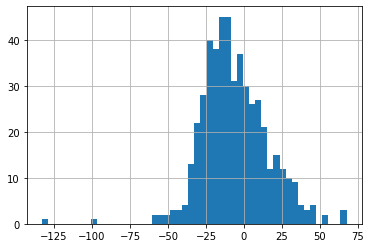

In [390]:
#histogram of pnl
macd_bt.transaction_history[macd_bt.transaction_history.type ==0]['pnl'].hist(bins = 50)

# The portfolio_tracker records the # of bids, length of positions, cash value, position value, total value at each ti. 
# The bah column is the value assuming we buy all the tickers when it begins

In [391]:
macd_bt.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2022-08-29 09:30:00-04:00,0,0,100000.000000,0.0,100000.000000,100000.000000
1,2022-08-29 09:45:00-04:00,0,0,100000.000000,0.0,100000.000000,100036.746521
2,2022-08-29 10:00:00-04:00,0,0,100000.000000,0.0,100000.000000,100090.820918
3,2022-08-29 10:15:00-04:00,0,0,100000.000000,0.0,100000.000000,100127.100478
4,2022-08-29 10:30:00-04:00,0,0,100000.000000,0.0,100000.000000,99891.468087
...,...,...,...,...,...,...,...
666,2022-10-10 15:00:00-04:00,0,0,96993.991774,0.0,96993.991774,89660.020085
667,2022-10-10 15:15:00-04:00,0,0,96993.991774,0.0,96993.991774,89584.912852
668,2022-10-10 15:30:00-04:00,0,0,96993.991774,0.0,96993.991774,89612.767757
669,2022-10-10 15:45:00-04:00,0,0,96993.991774,0.0,96993.991774,89428.480737


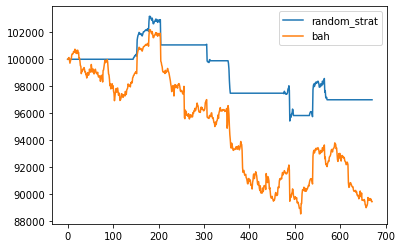

In [392]:
macd_bt.plot()

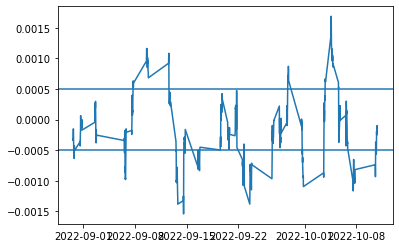

In [378]:
trend = data.pct_change().mean(axis = 1).ewm(com=0.1).mean().rolling(30).mean()
plt.axhline(0.0005)
plt.axhline(-0.0005)
plt.plot(trend)

In [263]:
t1 = trend.gt(0).rolling(100).mean()

In [276]:
trend = data.pct_change().mean(axis = 1).ewm(com=0.5).mean().rolling(100).mean()

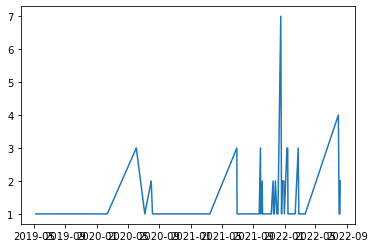

In [243]:
plt.plot(macd_bt.transaction_history[macd_bt.transaction_history.type ==1].groupby('dt')['type'].sum())

# 

# Upload to dashboard
## the upload_to_dashboard method will upload this graph to dashboard.
## make sure the crediential file "algo-trade-dashboard-80cae071e907.json" is under current directory, also install the related packages in requirements.txt

## to upload, call the function with the strategy name, if the name already exist in the gcloud, the previous data will be overwritten

In [38]:
macd_bt.upload_to_dashboard("MACD")

Data uploaded.


# Check on dashboard:
https://tigaji-algo-trade-dashboard-dashboard-gv8r0a.streamlitapp.com/